# Code for Figures

[Download the notebook](https://github.com/neuro4ml/neuro4ml.github.io/blob/main/materials/w1/w1-models.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuro4ml/neuro4ml.github.io/blob/main/materials/w1/w1-models.ipynb)

The code below generates the figures used in the notebooks, and might be useful to explore these ideas further.

It makes use of the [Brian spiking neural network simulator package](https://briansimulator.org/). Feel free to have a play with this and explore its [documentation](https://brian2.readthedocs.io/en/stable/), including excellent tutorials.

In [1]:
!pip install brian2
import os
from brian2 import *
prefs.codegen.target = 'numpy'


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Level of abstraction

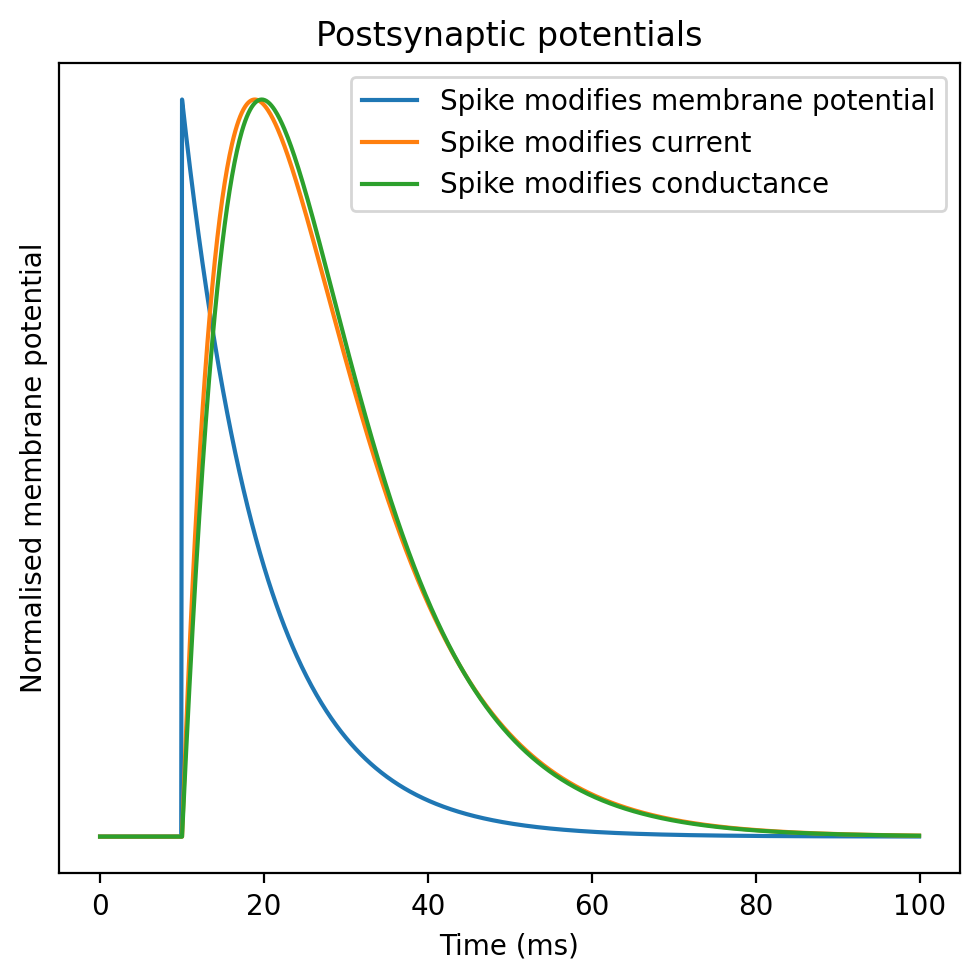

In [20]:
start_scope()

tau = 10*ms
taux = 8*ms
taug = 8*ms
eqs = '''
dv/dt=-v/tau:1
du/dt=((taux/tau)**(-tau/(tau-taux))*x-u)/tau:1
dx/dt=-x/taux:1
dz/dt=(I-z)/tau:1
I=g*(z+1):1
dg/dt=-g/taug:1
'''
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, ('v', 'u', 'z'), record=True)
run(10*ms)
G.v = 1
G.x = 1
G.g = 1
run(90*ms)
def normed(x):
    return x/amax(x)
figure(figsize=(5, 5), dpi=200)
plot(M.t/ms, M.v[0], label='Spike modifies membrane potential')
plot(M.t/ms, normed(M.u[0]), label='Spike modifies current')
plot(M.t/ms, normed(M.z[0]), label='Spike modifies conductance')
xlabel('Time (ms)')
ylabel('Normalised membrane potential')
yticks([])
legend(loc='upper right')
title('Postsynaptic potentials')
tight_layout();

## Postsynaptic potential forms

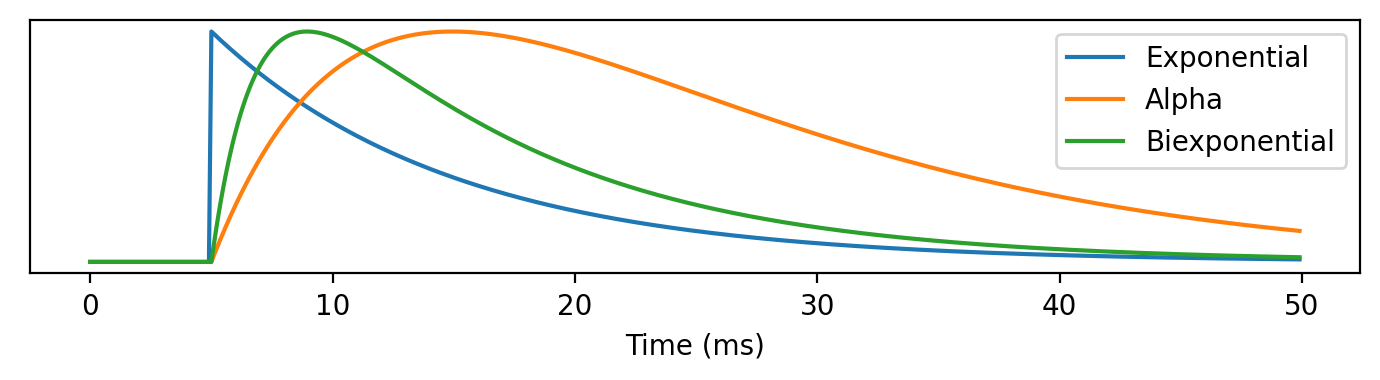

In [29]:
start_scope()

tau = 10*ms
tau2 = 2*ms
eqs = '''
dv/dt=-v/tau:1
du/dt=(x-u)/tau:1
dx/dt=-x/tau:1
dz/dt=(I-z)/tau:1
dI/dt=-I/tau2:1
'''
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, ('v', 'u', 'z'), record=True)
run(5*ms)
G.v = 1
G.x = 1
G.I = 1
run(45*ms)
def normed(x):
    return x/amax(x)
figure(figsize=(7, 2), dpi=200)
plot(M.t/ms, normed(M.v[0]), label='Exponential')
plot(M.t/ms, normed(M.u[0]), label='Alpha')
plot(M.t/ms, normed(M.z[0]), label='Biexponential')
xlabel('Time (ms)')
yticks([])
legend(loc='upper right')
tight_layout();

## Short term synaptic plasticity

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'u += U * (1.0 - u) (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'u += U * (1.0 - u) (in-place)'
 [brian2.codegen.generators.base]


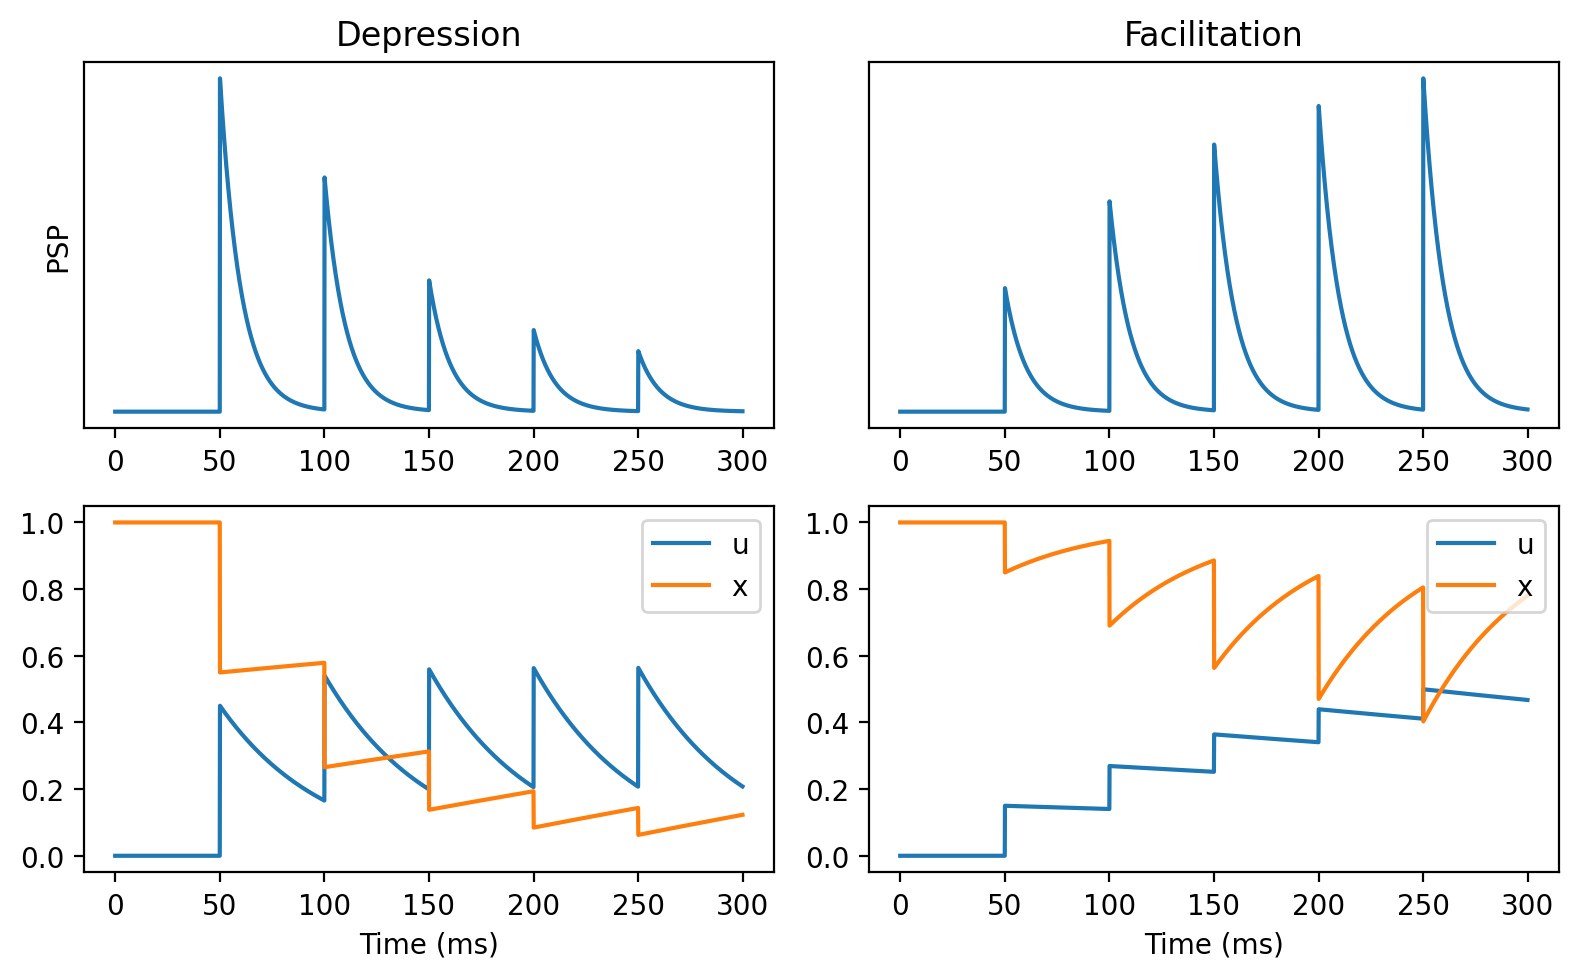

In [55]:
start_scope()
def runit(offset, tau, tauf, taud, U):
    eqs = '''
    dv/dt = -v/tau : 1
    du/dt = -u/tauf : 1
    dx/dt = (1-x)/taud : 1
    '''
    H = SpikeGeneratorGroup(1, [0]*5, np.arange(1, 6)*50*ms)
    G = NeuronGroup(1, eqs, method='euler')
    G.x = 1
    S = Synapses(H, G, on_pre='u += U*(1-u); v += u*x; x -= u*x;')
    S.connect(p=1)
    M = StateMonitor(G, ('v', 'u', 'x'), record=True)
    run(300*ms)
    subplot(2, 2, 1+offset)
    if offset:
        title('Facilitation')
    else:
        title('Depression')
    plot(M.t/ms, M.v[0])
    yticks([])
    if offset==0:
        ylabel('PSP')
    subplot(2, 2, 3+offset)
    plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.x[0], label='x')
    legend(loc='upper right')
    xlabel('Time (ms)')

figure(figsize=(8, 5), dpi=200)
runit(0, tau=10*ms, tauf=50*ms, taud=750*ms, U=0.45)
runit(1, tau=10*ms, tauf=750*ms, taud=50*ms, U=0.15)
tight_layout();

## Coincidence detection

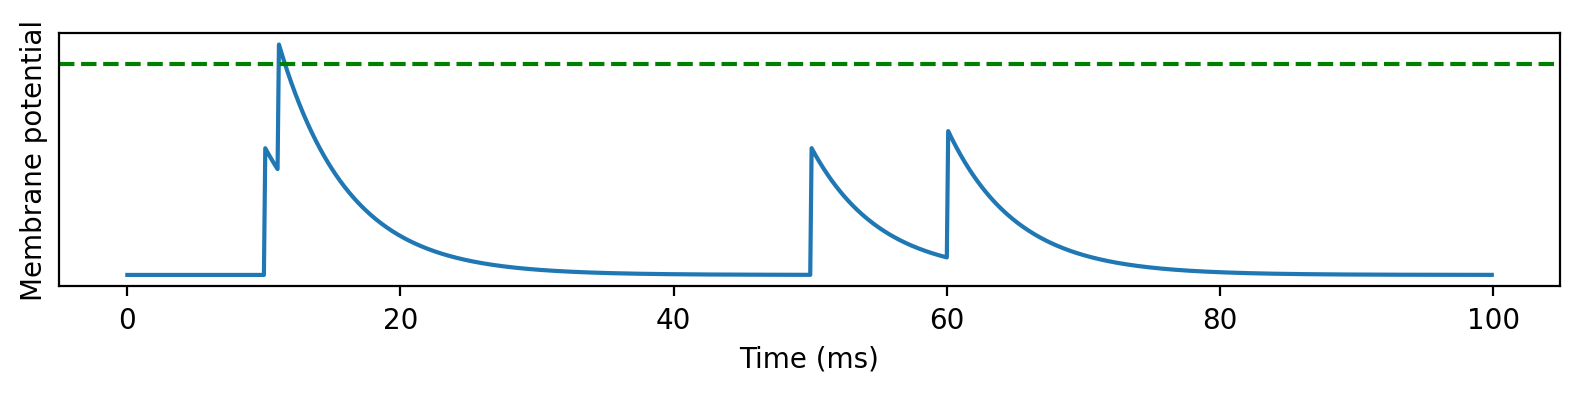

In [96]:
start_scope()
tau = 5*ms
eqs = '''
dv/dt = -v/tau : 1
'''
H = SpikeGeneratorGroup(1, [0, 0, 0, 0], [10*ms, 11*ms, 50*ms, 60*ms])
G = NeuronGroup(1, eqs)
S = Synapses(H, G, on_pre='v += 0.6', method='exact')
S.connect(p=1)
M = StateMonitor(G, 'v', record=True)
run(100*ms)
figure(figsize=(8, 2), dpi=200)
plot(M.t/ms, M.v[0])
axhline(1, ls='--', c='g')
xlabel('Time (ms)')
ylabel('Membrane potential')
yticks([])
tight_layout();


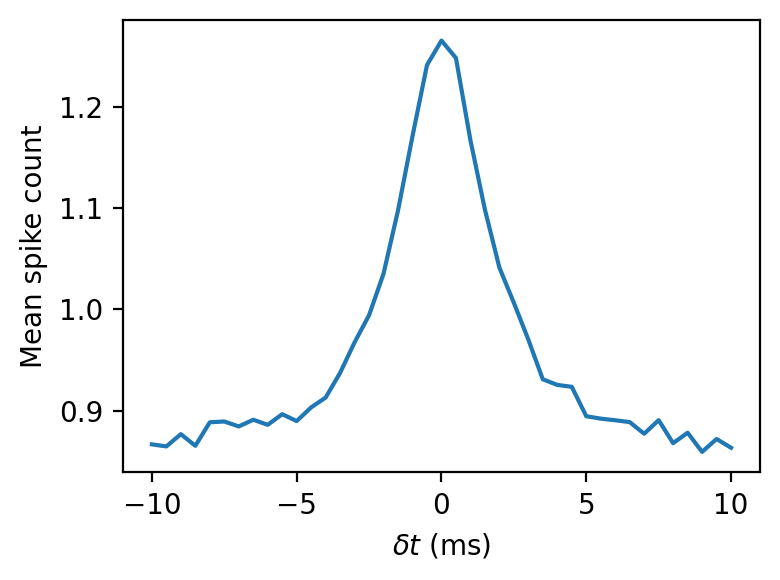

In [113]:
start_scope()

def firing_rate(delta_t, w, N=10000, tau=2*ms, sigma=0.3):
    eqs = '''
    dv/dt = -v/tau + sigma*xi*sqrt(2/tau) : 1
    '''
    H = SpikeGeneratorGroup(2, [0, 1], [150*ms, 150*ms+delta_t])
    G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
    S = Synapses(H, G, on_pre='v += w')
    M = SpikeMonitor(G)
    S.connect(p=1)
    run(200*ms)
    return mean(M.count)#/(200*ms)

DELTA_T = np.linspace(-10, 10, 41)*ms
FR = np.array([firing_rate(delta_t, w=0.8) for delta_t in DELTA_T])
figure(figsize=(4, 3), dpi=200)
plot(DELTA_T/ms, FR)
xlabel(r'$\delta t$ (ms)')
ylabel('Mean spike count')
tight_layout();

## Bayesian decoder

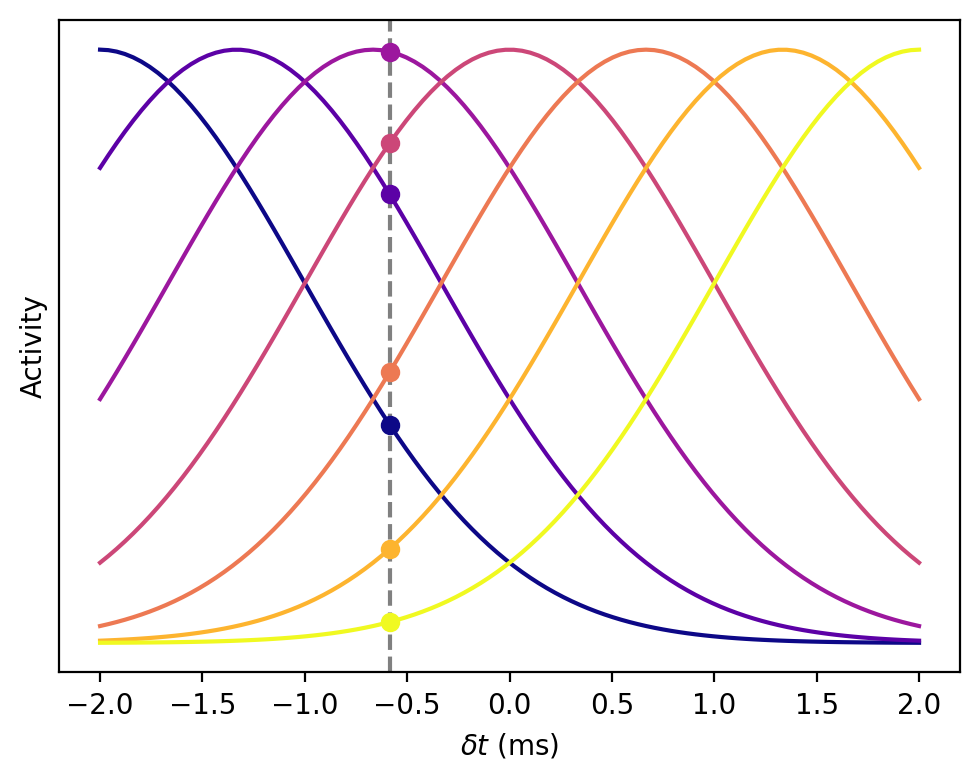

In [111]:
from matplotlib.cm import plasma
deltat = np.linspace(-2, 2, 100)
width = 1
N = 7
centres = np.linspace(-2, 2, N)
i = 35
figure(figsize=(5, 4), dpi=200)
for centre in centres:
    y = exp(-(centre-deltat)**2/(2*width**2))
    c = plasma((centre+2)/4)
    plt.plot(deltat, y, c=c)
    plt.plot(deltat[i], y[i], 'o', c=c)
plt.axvline(deltat[i], ls='--', c='gray', zorder=-1)
xlabel(r'$\delta t$ (ms)')
ylabel('Activity')
yticks([])
tight_layout();